In [43]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import pickle

from utils.model import Metrics, save_model, load_model

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200

SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from utils.pipeline import Pipeline, PipelineStep

from utils.helpers import reduce_mem_usage
from transform.set_missings import set_missings, drop_fraud
from transform.load_data import load_train_data, load_test_data
from transform.feature_selection import feature_selection
from transform.dpi_features import generate_test_dpi_feature, generate_train_dpi_feature
from transform.bnum_features import generate_test_bnum_feature, generate_train_bnum_feature
from transform.fe_features import generate_test_fe_feature, generate_train_fe_feature


def remove_abon_id(df):
    return df.drop("abon_id", axis=1)


transform_train_pipeline = Pipeline(
    "TRANSFORM_TRAIN",
    [
        # Load data
        PipelineStep(load_train_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_train_fe_feature),
        PipelineStep(generate_train_dpi_feature),
        PipelineStep(generate_train_bnum_feature),
        PipelineStep(drop_fraud),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

transform_test_pipeline = Pipeline(
    "TRANSFORM_TEST",
    [
        # Load data
        PipelineStep(load_test_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_test_fe_feature),
        PipelineStep(generate_test_dpi_feature),
        PipelineStep(generate_test_bnum_feature),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

train_data = transform_train_pipeline.run()

train_data.target = train_data.target.astype(int)

print("Shape:", train_data.shape)

2024-07-16 23:42:58 - Running pipeline: TRANSFORM_TRAIN (0:23:57)
2024-07-16 23:42:58 - 0. Running step: load_train_data (0:23:57)
2024-07-16 23:42:58 - 1. Running step: set_missings (0:23:57)
2024-07-16 23:43:01 - 2. Running step: reduce_mem_usage (0:24:00)
2024-07-16 23:43:01 - 3. Running step: generate_train_fe_feature (0:24:00)


Mem. usage decreased to 226.02 Mb (75.5% reduction)


2024-07-16 23:43:02 - 4. Running step: generate_train_dpi_feature (0:24:01)
2024-07-16 23:43:02 - 5. Running step: generate_train_bnum_feature (0:24:02)
2024-07-16 23:43:03 - 6. Running step: drop_fraud (0:24:02)
2024-07-16 23:43:03 - 7. Running step: remove_abon_id (0:24:03)
2024-07-16 23:43:04 - 8. Running step: feature_selection (0:24:03)
2024-07-16 23:43:04 - 10. Done (0:24:03)


-----------------

Shape: (149998, 58)


In [45]:
from transform.load_data import LoadData

loader = LoadData()

NOT_CHURNED_CLIENT_TITLE = "Клієнти що залишись"
CHURNED_CLIENT_TITLE = "Клієнти що пішли"

NOT_CHURNED_COLOR = "#80CAFF"
CHURNED_COLOR = "#FFAFA3"

SNS_TARGET_LABELS = [CHURNED_CLIENT_TITLE, NOT_CHURNED_CLIENT_TITLE]

# loader.df_train_fe -> (150000, 817)
# loader.df_test_fe -> (150000, 817)

# loader.df_train_bnum -> (671248, 8)
# loader.df_test_bnum -> (669540, 8)

# loader.df_train_dpi -> (6745887, 6)
# loader.df_test_dpi -> (6739211, 6)

In [4]:
import plotly.graph_objects as go

target_values = loader.df_train_fe.target.value_counts().values

labels = [
    f"{NOT_CHURNED_CLIENT_TITLE} ({target_values[0]})",
    f"{CHURNED_CLIENT_TITLE} ({target_values[1]})",
]
values = loader.df_train_fe.target.value_counts().values

fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            insidetextfont=dict(size=18, color="white"),
            outsidetextfont=dict(size=14, color="black"),
            marker=dict(colors=[NOT_CHURNED_COLOR, CHURNED_COLOR]),
        )
    ]
)

fig.update_layout(
    title="Розподіл клієнтів по цільовому значенню",
    autosize=True,
    width=800,
    height=500,
    font=dict(size=14),
    legend=dict(font=dict(size=16)),
    margin=dict(l=20, r=250, t=100, b=20),
)

fig.show()

fig.write_image("target_pie.png", scale=3)

In [6]:
df = set_missings(loader.df_train_fe.copy())

not_churn_clients = df[df.target == 0]
churn_clients = df[df.target == 1]

In [7]:
missing_values = loader.df_train_fe.isnull().sum() * 100 / len(loader.df_train_fe)

missing_values.device_days_usage

4.823333333333333

In [8]:
# import plotly.figure_factory as ff
# import numpy as np

# # Generate sample data
# data1 = not_churn_clients.device_days_usage
# data2 = churn_clients.device_days_usage

# # Create distribution plots
# fig = ff.create_distplot(
#     [data1, data2],
#     group_labels=[NOT_CHURNED_CLIENT_TITLE, CHURNED_CLIENT_TITLE],
#     bin_size=10,
# )

# # Update layout for better visualization
# fig.update_layout(
#     title="Розподіл клієнтів по 'Кількості днів використання'",
#     xaxis_title="Кількість днів",
#     yaxis_title="Щільність",
#     autosize=True,
#     width=800,
#     height=500,
#     font=dict(size=14),
#     legend=dict(font=dict(size=16)),
#     margin=dict(l=20, r=250, t=100, b=20),
# )

# # Show plot
# fig.show()

# fig.write_image("device_days_usage_distribution.png", scale=3)

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


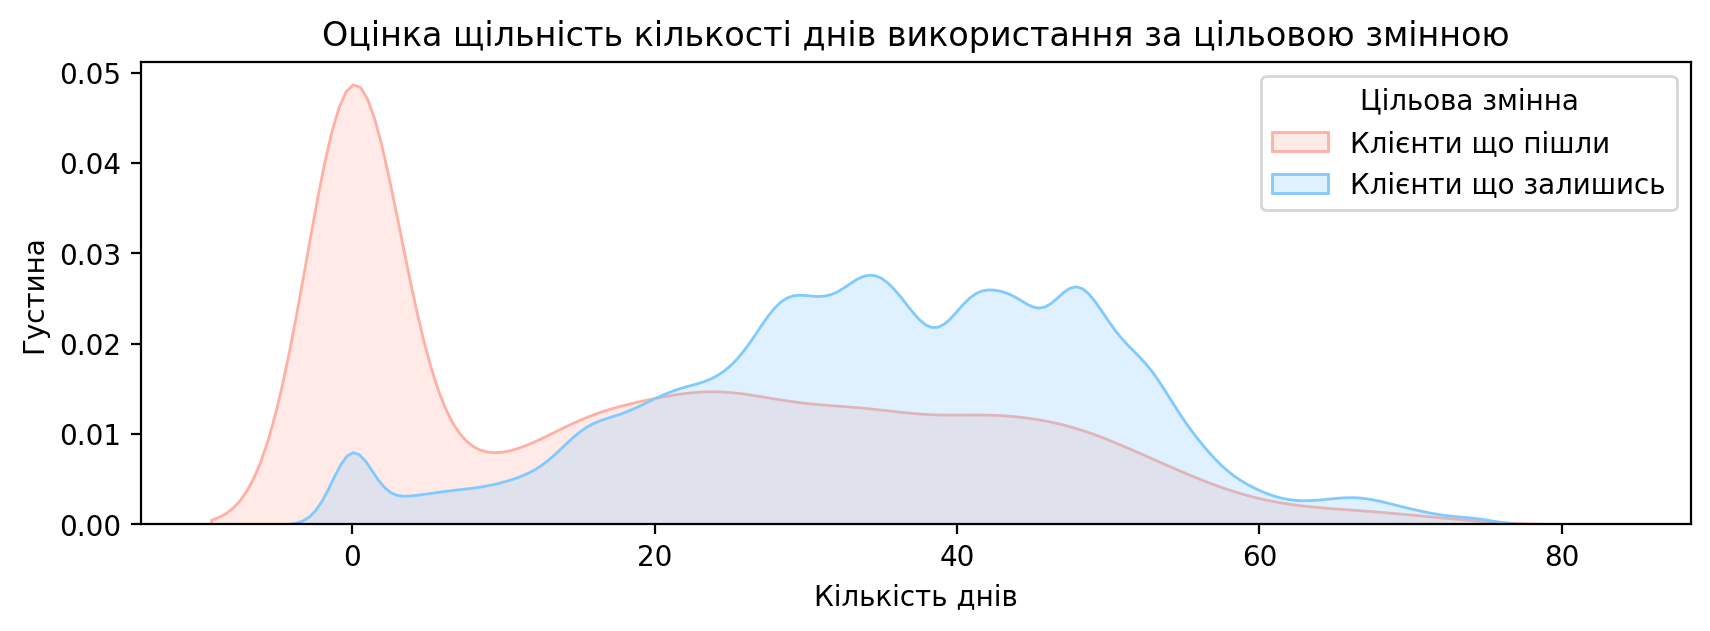

<Figure size 1280x960 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=df,
    x="device_days_usage",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
plt.title("Оцінка щільність кількості днів використання за цільовою змінною")
plt.xlabel("Кількість днів")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("device_days_usage_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


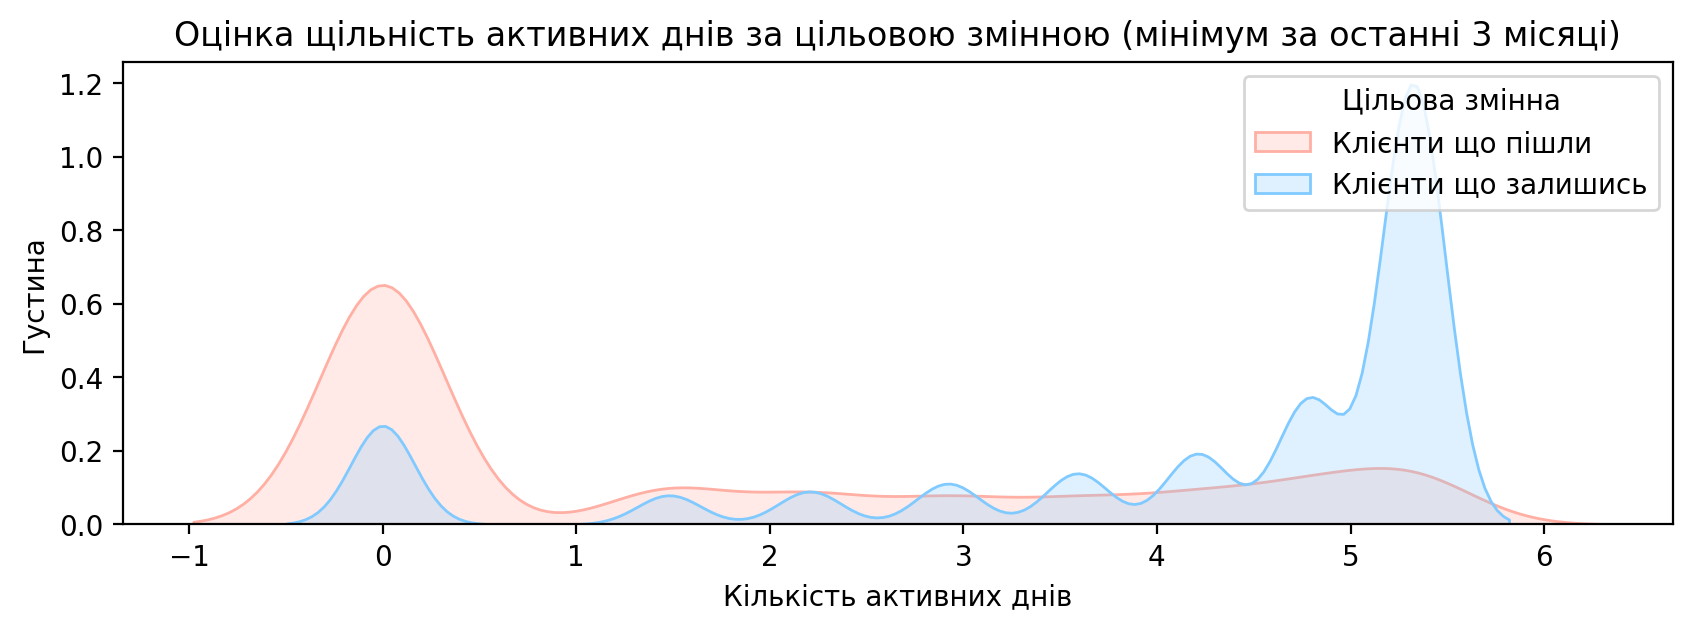

<Figure size 1280x960 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=df,
    x="num_act_days_min_mnt3",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
plt.title("Оцінка щільність активних днів за цільовою змінною (мінімум за останні 3 місяці)")
plt.xlabel("Кількість активних днів")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("num_act_days_min_mnt3_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


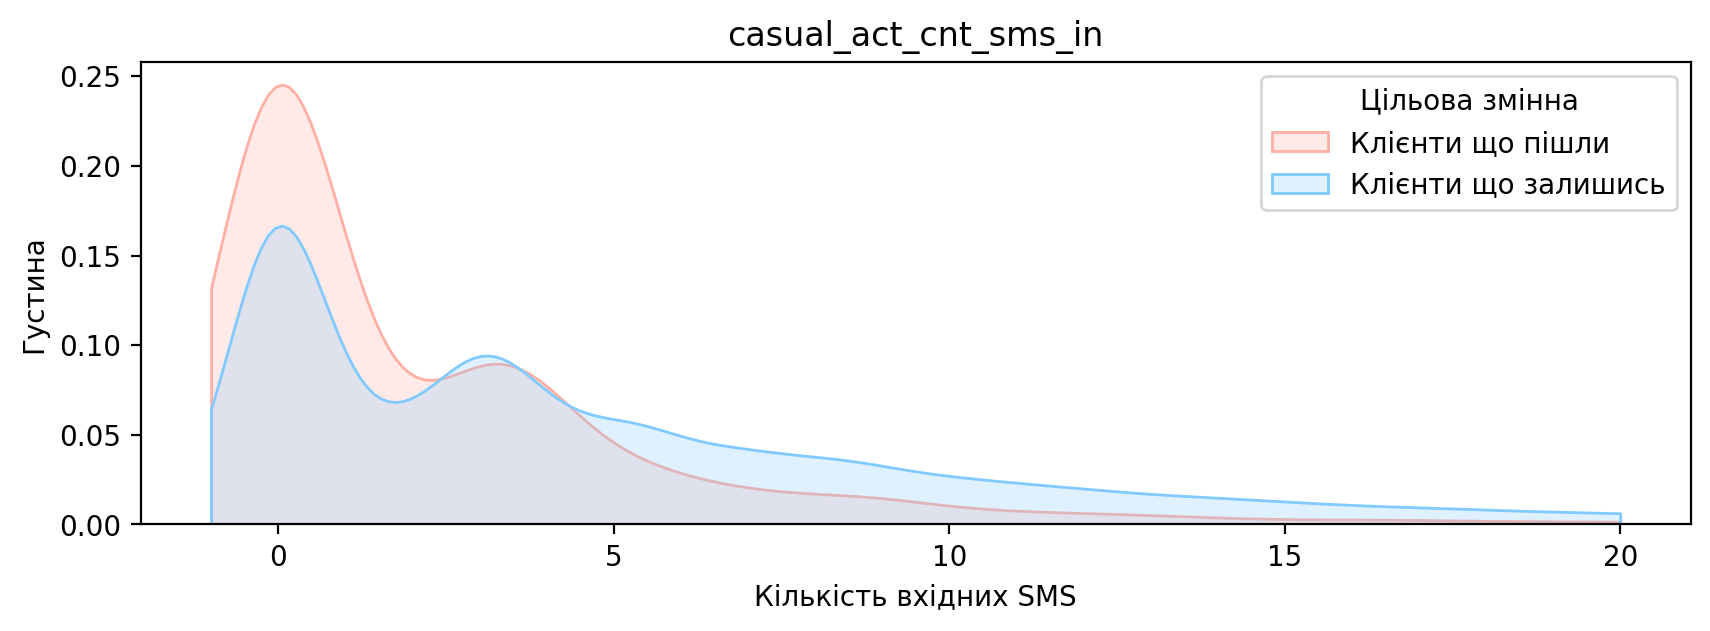

<Figure size 1280x960 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="casual_act_cnt_sms_in",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(-1, 20),
)
plt.title("casual_act_cnt_sms_in")
plt.xlabel("Кількість вхідних SMS")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("casual_act_cnt_sms_in_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


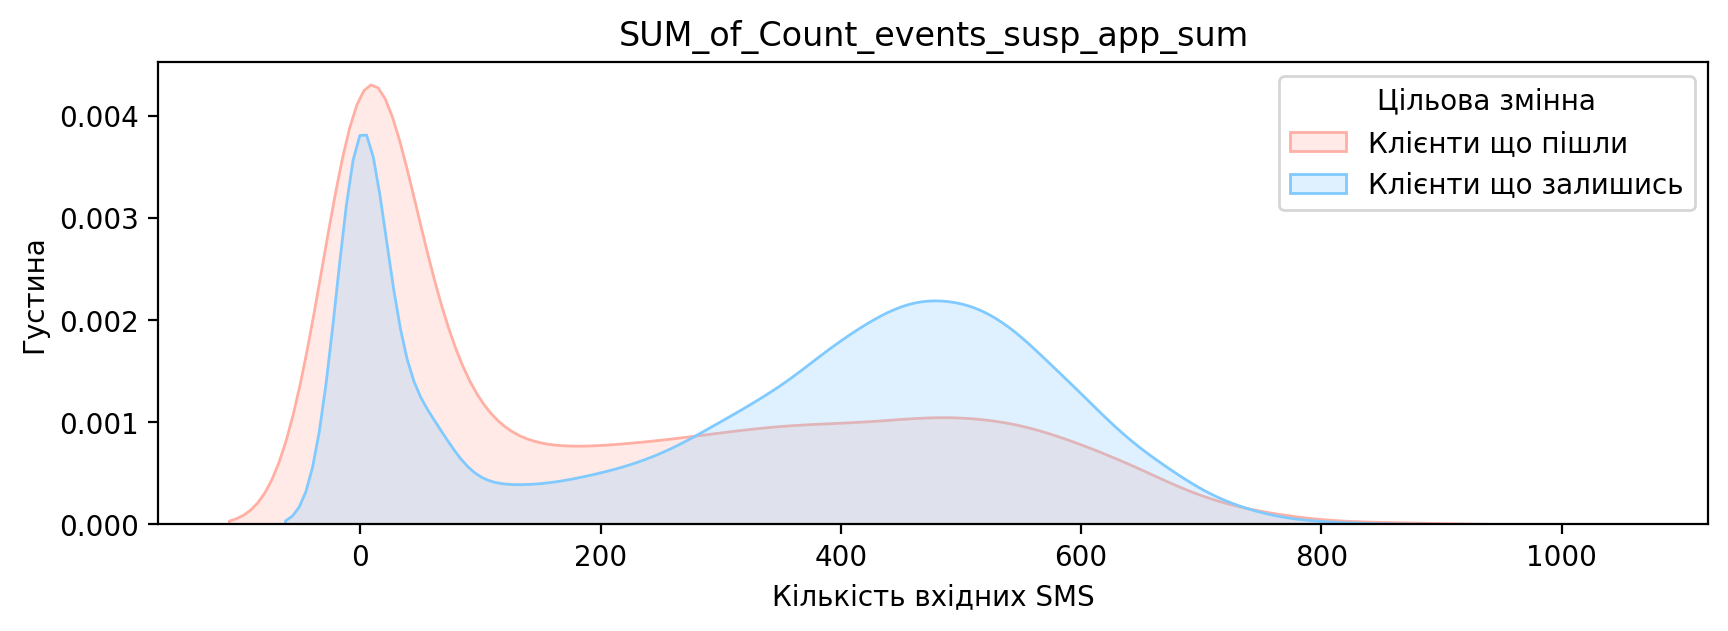

<Figure size 1280x960 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="SUM_of_Count_events_susp_app_sum",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
plt.title("SUM_of_Count_events_susp_app_sum")
plt.xlabel("Кількість вхідних SMS")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("casual_act_cnt_sms_in_kde.png")